## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему. 

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv` 



### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно. 

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**

In [1]:
pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 72.2 MB/s eta 0:00:00:00:010:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import scipy.sparse as sp
from more_itertools import pairwise
from itertools import islice, cycle
from implicit.nearest_neighbours import CosineRecommender
from implicit.cpu.bpr import BayesianPersonalizedRanking
from implicit.cpu.als import AlternatingLeastSquares
from implicit.cpu.lmf import LogisticMatrixFactorization

pd.options.mode.chained_assignment = None

In [97]:
train_data = pd.read_csv('/kaggle/input/recasts-hw3/train_part.csv')
train_data.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,2021-03-13,4485,98.0,1
1,952323,15997,2021-03-13,7507,100.0,1
2,889459,11460,2021-03-13,60,0.0,0
3,854016,11237,2021-03-13,5381,98.0,1
4,307257,9132,2021-03-13,5814,100.0,1


In [98]:
train_data['last_watch_dt'] = pd.to_datetime(train_data['last_watch_dt'], format = '%Y-%m-%d')

In [5]:
train_data['target'].value_counts()

target
0    2727168
1    2139788
Name: count, dtype: int64

In [99]:
def memory_optimize(df, name):
    col_max = df[name].max()
    col_min = df[name].min()

    if col_max <  np.iinfo("int8").max and col_min > np.iinfo("int8").min:
        df[name] = df[name].astype("int8")
    elif col_max <  np.iinfo("int16").max and col_min > np.iinfo("int16").min:
        df[name] = df[name].astype("int16")
    elif col_max <  np.iinfo("int32").max and col_min > np.iinfo("int32").min:
        df[name] = df[name].astype("int32")
    elif col_max <  np.iinfo("int64").max and col_min > np.iinfo("int64").min:
        df[name] = df[name].astype("int64")

In [100]:
memory_optimize(train_data, name='user_id')
memory_optimize(train_data, name='item_id')
memory_optimize(train_data, name='total_dur')

In [8]:
train_data.dtypes

user_id                   int32
item_id                   int16
last_watch_dt    datetime64[ns]
total_dur                 int32
watched_pct             float64
target                    int64
dtype: object

q=0.6 чтоб оставить побольше данных для обучения катбуста

In [8]:
def split_data(df, q=0.6):
    
    knn_date_threshold = df['last_watch_dt'].quantile(q=q, interpolation='nearest')
    cands_train = df[df['last_watch_dt'] < knn_date_threshold]
    cands_pred = df[df['last_watch_dt'] >= knn_date_threshold]

    return cands_train, cands_pred

In [9]:
cands_train, cands_pred = split_data(train_data)

In [42]:
cands_train['last_watch_dt'].max()

Timestamp('2021-07-03 00:00:00')

In [43]:
cands_pred['last_watch_dt'].min()

Timestamp('2021-07-04 00:00:00')

In [13]:
cands_train.shape

(2886183, 6)

In [14]:
cands_pred.shape

(1980773, 6)

In [10]:
#определяем холодных пользователей, им будем рекомендовать популярное
cands_pred_cold = cands_pred[~cands_pred['user_id'].isin(cands_train['user_id'].unique())]
cands_pred_cold.drop_duplicates(subset=['user_id', 'item_id'], inplace=True)
cands_pred_cold.shape

(1000344, 6)

In [11]:
#в тестовой части для расчета метрик моделей первого уровня оставляем только теплых пользователей
cands_pred_hot = cands_pred[cands_pred['user_id'].isin(cands_train['user_id'].unique())]
cands_pred_hot.drop_duplicates(subset=['user_id', 'item_id'], inplace=True)
cands_pred_hot.shape

(980429, 6)

In [12]:
users_inv_mapping = dict(enumerate(train_data['user_id'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}
print(len(users_mapping))
items_inv_mapping = dict(enumerate(train_data['item_id'].unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}
print(len(items_mapping))

880421
15418


для обучения моделей первого уровня будем использовать все данные и 0 и 1

In [13]:
def get_coo_matrix(df,
                   user_col='user_id',
                   item_col='item_id',
                   weight_col=None,
                   users_mapping=users_mapping,
                   items_mapping=items_mapping):
    if weight_col is None:
        weights = np.ones(len(df), dtype=np.float32)
    else:
        weights = df[weight_col].astype(np.float32)

    interaction_matrix = sp.coo_matrix((
        weights,
        (
            df[user_col].map(users_mapping.get),
            df[item_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix

In [14]:
train_mat = get_coo_matrix(cands_train)
train_mat = train_mat.tocsr()
train_mat

<595870x14259 sparse matrix of type '<class 'numpy.float32'>'
	with 2886183 stored elements in Compressed Sparse Row format>

In [15]:
cosine_model = CosineRecommender(K=5000)
cosine_model.fit(train_mat)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.020903825759887695 seconds
  warnings.warn(


  0%|          | 0/14259 [00:00<?, ?it/s]

In [16]:
bpr_model = BayesianPersonalizedRanking()
bpr_model.fit(train_mat)

  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
als_model = AlternatingLeastSquares()
als_model.fit(train_mat)

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()
/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [23]:
lmf_model = LogisticMatrixFactorization()
lmf_model.fit(train_mat)

  0%|          | 0/30 [00:00<?, ?it/s]

In [17]:
def generate_implicit_recs_mapper(model, train_matrix, N, user_mapping, item_inv_mapping):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        ids, scores = model.recommend(
            user_id,
            train_matrix[user_id],
            N=N,
            filter_already_liked_items=True
        )
        recs = [(item_inv_mapping[item], score) for item, score in zip(ids, scores)]
        return recs  
    return _recs_mapper

In [18]:
mapper_cos = generate_implicit_recs_mapper(cosine_model, train_mat, 30, users_mapping, items_inv_mapping)

In [19]:
mapper_bpr = generate_implicit_recs_mapper(bpr_model, train_mat, 30, users_mapping, items_inv_mapping)

In [27]:
mapper_als = generate_implicit_recs_mapper(als_model, train_mat, 30, users_mapping, items_inv_mapping)

In [28]:
mapper_lmf = generate_implicit_recs_mapper(lmf_model, train_mat, 30, users_mapping, items_inv_mapping)

KNN

далее во всех можелях беру не скоры а ранки. и то и то было дольше (((

In [22]:
recs_cos = pd.DataFrame({'user_id': cands_pred_hot['user_id'].unique()})
recs_cos['item_score'] = recs_cos['user_id'].map(mapper_cos)

recs_cos = recs_cos.explode('item_score')
recs_cos[['item_id', 'score']] = pd.DataFrame(recs_cos['item_score'].tolist(), index=recs_cos.index)

recs_cos['rank'] = recs_cos.groupby('user_id').cumcount() + 1

recs_cos = recs_cos[['user_id', 'item_id', 'score', 'rank']]
recs_cos

,user_id,item_id,score,rank
0,499619,9728,0.613524,1
0,499619,10440,0.591319,2
0,499619,3734,0.450590,3
0,499619,4880,0.441682,4
0,499619,142,0.425006,5
...,...,...,...,...
190750,509102,8481,0.058445,26
190750,509102,1287,0.057806,27
190750,509102,12275,0.057661,28
190750,509102,13500,0.056895,29


BPR

In [24]:
recs_bpr = pd.DataFrame({'user_id': cands_pred_hot['user_id'].unique()})
recs_bpr['item_score'] = recs_bpr['user_id'].map(mapper_bpr)

recs_bpr = recs_bpr.explode('item_score')
recs_bpr[['item_id', 'score']] = pd.DataFrame(recs_bpr['item_score'].tolist(), index=recs_bpr.index)

recs_bpr['rank'] = recs_bpr.groupby('user_id').cumcount() + 1

recs_bpr = recs_bpr[['user_id', 'item_id', 'score', 'rank']]
recs_bpr

,user_id,item_id,score,rank
0,499619,10755,2.745618,1
0,499619,6404,2.431504,2
0,499619,10219,2.412618,3
0,499619,6907,2.336325,4
0,499619,8251,2.329560,5
...,...,...,...,...
190750,509102,7626,1.066411,26
190750,509102,12406,1.055841,27
190750,509102,13678,1.054323,28
190750,509102,4073,1.053125,29


ALS

In [31]:
recs_als = pd.DataFrame({'user_id': cands_pred_hot['user_id'].unique()})
recs_als['item_id'] = recs_als['user_id'].map(mapper_als)
recs_als = recs_als.explode('item_id')
recs_als['rank'] = recs_als.groupby('user_id').cumcount() + 1
recs_als

,user_id,item_id,rank
0,499619,14476,1
0,499619,10219,2
0,499619,8486,3
0,499619,13411,4
0,499619,2043,5
...,...,...,...
190750,509102,12849,26
190750,509102,12132,27
190750,509102,15739,28
190750,509102,3402,29


LMF

In [32]:
recs_lmf = pd.DataFrame({'user_id': cands_pred_hot['user_id'].unique()})
recs_lmf['item_id'] = recs_lmf['user_id'].map(mapper_lmf)
recs_lmf = recs_lmf.explode('item_id')
recs_lmf['rank'] = recs_lmf.groupby('user_id').cumcount() + 1
recs_lmf

,user_id,item_id,rank
0,499619,16509,1
0,499619,3948,2
0,499619,12335,3
0,499619,15399,4
0,499619,9433,5
...,...,...,...
190750,509102,14517,26
190750,509102,8403,27
190750,509102,6185,28
190750,509102,11255,29


In [6]:
def compute_recall(df_true, df_pred, top_N, rank_col='rank'):
    # Объединяем истинные и предсказанные данные
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', rank_col])
    
    # Считаем количество релевантных товаров для каждого пользователя
    test_recs['relevant_items_count'] = test_recs.groupby('user_id')['rank'].transform('size')
    
    # Количество уникальных пользователей
    users_count = test_recs.index.get_level_values('user_id').nunique()
    
    # Вычисляем Recall@k
    k = top_N
    hit_k = f'hit@{k}'
    test_recs[hit_k] = test_recs[rank_col] <= k
    
    # Recall = (кол-во релевантных в топ-k) / (общее кол-во релевантных для пользователя)
    recall = (test_recs.groupby('user_id')[hit_k].sum() / test_recs.groupby('user_id')['relevant_items_count'].first()).mean()
    
    return float(recall)

In [166]:
def compute_gini_diversity(df_pred, top_N=30, rank_col='rank'):
    # Берем только топ-N рекомендаций для каждого пользователя
    top_recommendations = df_pred[df_pred[rank_col] <= top_N]
    
    # Считаем, сколько раз каждый товар был рекомендован в топ-N
    item_counts = top_recommendations['item_id'].value_counts().values
    
    # Если нет рекомендаций, возвращаем 0
    if len(item_counts) == 0:
        return 0.0
    
    # Вычисляем Gini Diversity
    gini_diversity = _compute_diversity_gini(item_counts)
    
    return float(gini_diversity)

def _compute_diversity_gini(recommended_counter):

    n_items = len(recommended_counter)
    recommended_counter_sorted = np.sort(recommended_counter)  # значения должны быть отсортированы
    index = np.arange(1, n_items+1)  # индекс для каждого элемента
    
    # Формула Gini Diversity
    gini_diversity = 2 * np.sum((n_items + 1 - index)/(n_items+1) * recommended_counter_sorted/np.sum(recommended_counter_sorted))
    
    return gini_diversity

In [35]:
recall_cos = compute_recall(cands_pred_hot, recs_cos, 30) #K=2000
recall_cos

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


0.29535138457879356

In [36]:
gini_diversity_cos = compute_gini_diversity(recs_cos, top_N=30)
gini_diversity_cos

0.04211622372798868

In [37]:
recall_bpr = compute_recall(cands_pred_hot, recs_bpr, 30) #bpr
recall_bpr

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


0.15962425526341745

In [38]:
gini_diversity_bpr = compute_gini_diversity(recs_bpr, top_N=30)
gini_diversity_bpr

0.29453829427775136

In [39]:
recall_als = compute_recall(cands_pred_hot, recs_als, 30) #als
recall_als

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


0.05758562199301547

In [40]:
gini_diversity_als = compute_gini_diversity(recs_als, top_N=30)
gini_diversity_als

0.29981926954197174

In [41]:
recall_lmf = compute_recall(cands_pred_hot, recs_lmf, 30) #lmf
recall_lmf

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


0.03995738349009549

In [42]:
gini_diversity_lmf = compute_gini_diversity(recs_lmf, top_N=30)
gini_diversity_lmf

0.24083553787035594

выбор очевиден - берем bpr

In [25]:
pip install rectools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.0/202.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 47.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: attrs
    Found existing installation: attrs 25.1.0
    Uninstalling attrs-25.1.0:
      Successfully uninstalled attrs-25.1.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
langchain 0.3.12 requires async-timeout<5.0.0,>=4.0.0; python_version < "3.11", but you have async

In [26]:
import numpy as np
import os
import pandas as pd
import torch
import typing as tp
import warnings
import threadpoolctl
import re
import plotly.express as px

from lightning_fabric import seed_everything
from pathlib import Path

from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import (
    MAP,
    CoveredUsers,
    AvgRecPopularity,
    Intersection,
    HitRate,
    Serendipity,
)
from rectools.models import PopularModel, EASEModel, SASRecModel, BERT4RecModel
from rectools.model_selection import TimeRangeSplitter, cross_validate
from rectools.models.nn.item_net import CatFeaturesItemNet, IdEmbeddingsItemNet
from rectools.visuals import MetricsApp

warnings.simplefilter("ignore")

# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Random seed
RANDOM_STATE=60
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

60

In [27]:
interactions = (
    pd.read_csv('/kaggle/input/recasts-hw3/train_part.csv', parse_dates=["last_watch_dt"])
    .rename(columns={"last_watch_dt": Columns.Datetime})
)

In [28]:
# Process interactions
interactions[Columns.Weight] = 1
interactions = interactions[["user_id", "item_id", "datetime", "weight"]]
print(interactions.shape)
interactions.head(2)

(4866956, 4)


,user_id,item_id,datetime,weight
0,310745,13373,2021-03-13,1
1,952323,15997,2021-03-13,1


In [29]:
def split_data(df, q=0.6):
    
    knn_date_threshold = df['datetime'].quantile(q=q, interpolation='nearest')
    cands_train = df[df['datetime'] < knn_date_threshold]
    cands_pred = df[df['datetime'] >= knn_date_threshold]

    return cands_train, cands_pred

In [30]:
interactions, test = split_data(interactions)

In [31]:
cands_pred_hot = test[test['user_id'].isin(interactions['user_id'].unique())]
cands_pred_hot.drop_duplicates(subset=['user_id', 'item_id'], inplace=True)
cands_pred_hot.shape

(980429, 4)

In [32]:
dataset = Dataset.construct(
    interactions_df=interactions,
)

In [33]:
sasrec = SASRecModel(
    session_max_len=20,
    loss="softmax",
    n_factors=64,
    n_blocks=1,
    n_heads=4,
    dropout_rate=0.2,
    lr=0.001,
    batch_size=128,
    epochs=10,
    verbose=1,
    deterministic=True,
)

In [34]:
%%time
sasrec.fit(dataset);

Training: |          | 0/? [00:00<?, ?it/s]

CPU times: user 9min 48s, sys: 13.2 s, total: 10min 1s
Wall time: 9min 57s


In [35]:
recs_df = sasrec.recommend(
    users=cands_pred_hot['user_id'].unique(),  
    dataset=dataset,
    k=30,
    filter_viewed=True,
    on_unsupported_targets="warn"
)
recs_df

,user_id,item_id,score,rank
0,499619,9728,3.217241,1
1,499619,3734,2.976347,2
2,499619,10440,2.946949,3
3,499619,7102,2.496930,4
4,499619,15297,2.265164,5
...,...,...,...,...
5721925,509102,11310,0.976797,26
5721926,509102,11237,0.965328,27
5721927,509102,3804,0.961697,28
5721928,509102,6166,0.929692,29


In [64]:
# recs_df.drop(columns=['score'], inplace=True)

In [65]:
recall_sasrec = compute_recall(cands_pred_hot, recs_df, 30) 
gini_diversity_sasrec = compute_gini_diversity(recs_df, top_N=30)

In [36]:
class PopularRecommender():
    def __init__(self, max_K=200, days=30, item_column='item_id', dt_column='date'):
        self.max_K = max_K
        self.days = days
        self.item_column = item_column
        self.dt_column = dt_column
        self.recommendations = []
        
    def fit(self, df, ):
        min_date = df[self.dt_column].max().normalize() - pd.DateOffset(days=self.days)
        self.recommendations = df.loc[df[self.dt_column] > min_date, self.item_column].value_counts().head(self.max_K).index.values
    
    def recommend(self, users=None, N=30):
        recs = self.recommendations[:N]
        if users is None:
            return recs
        else:
            return list(islice(cycle([recs]), len(users)))

In [37]:
pop_model = PopularRecommender(days=30, dt_column='last_watch_dt')
pop_model.fit(cands_train)

In [58]:
top30_recs = pop_model.recommend(N=30)
top30_recs

array([10440, 15297, 13865,  9728,  2657,  3734,  4151, 12995,   142,
        4880,  4457,  9996,  4740,  1844,  7102,  7571, 14431,  1132,
        8636,  3935,  7417,  6809, 14901, 11778, 10464, 14703,  1449,
       11237,  6443, 16166], dtype=int16)

In [38]:
recs_pop = pd.DataFrame({'user_id': cands_pred['user_id'].unique()})
recs_pop['item_id'] = pop_model.recommend(recs_pop['user_id'], N=30)
recs_pop = recs_pop.explode('item_id')
recs_pop['rank'] = recs_pop.groupby('user_id').cumcount() + 1
recs_pop

,user_id,item_id,rank
0,499619,10440,1
0,499619,15297,2
0,499619,13865,3
0,499619,9728,4
0,499619,2657,5
...,...,...,...
475301,449050,14703,26
475301,449050,1449,27
475301,449050,11237,28
475301,449050,6443,29


In [60]:
recall_pop = compute_recall(cands_pred_hot, recs_pop, 30) 
gini_diversity_pop = compute_gini_diversity(recs_pop, top_N=30)

In [50]:
# recs_pop = recs_pop.rename(columns={'rank': 'rank_pop'})
# recs_cos = recs_cos.rename(columns={'rank': 'rank_cos'})
# recs_bpr = recs_bpr.rename(columns={'rank': 'rank_bpr'})
# recs_df = recs_df.rename(columns={'rank': 'rank_sasrec'})

# recs_cos = recs_cos.rename(columns={'score': 'score_cos'})
# recs_bpr = recs_bpr.rename(columns={'score': 'score_bpr'})
# recs_df = recs_df.rename(columns={'score': 'score_sasrec'})

merged_recs = recs_pop.merge(recs_cos, on=['user_id', 'item_id'], how='outer')
merged_recs = merged_recs.merge(recs_bpr, on=['user_id', 'item_id'], how='outer')
merged_recs = merged_recs.merge(recs_df, on=['user_id', 'item_id'], how='outer')

In [51]:
merged_recs[merged_recs['user_id'] == 499619]

,user_id,item_id,rank_pop,score_cos,rank_cos,score_bpr,rank_bpr,score_sasrec,rank_sasrec
10373852,499619,78,NaN,NaN,NaN,1.959008,22.0,NaN,NaN
10373853,499619,142,9.0,0.425006,5.0,NaN,NaN,0.999864,14.0
10373854,499619,182,NaN,NaN,NaN,1.951198,24.0,NaN,NaN
10373855,499619,372,NaN,NaN,NaN,NaN,NaN,0.838234,23.0
10373856,499619,1077,NaN,NaN,NaN,2.099720,12.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10373921,499619,14901,23.0,NaN,NaN,NaN,NaN,NaN,NaN
10373922,499619,15297,2.0,0.348465,14.0,NaN,NaN,2.265164,5.0
10373923,499619,15648,NaN,NaN,NaN,1.983802,18.0,NaN,NaN
10373924,499619,16096,NaN,NaN,NaN,1.970495,19.0,NaN,NaN


In [52]:
cols_to_fill = ['rank_pop', 'rank_cos', 'rank_bpr', 'rank_sasrec'] 
merged_recs[cols_to_fill] = merged_recs[cols_to_fill].fillna(10000)

In [53]:
cols_to_fill = ['score_cos', 'score_bpr', 'score_sasrec'] 
merged_recs[cols_to_fill] = merged_recs[cols_to_fill].fillna(0)

In [54]:
merged_recs[merged_recs['user_id'] == 499619]

,user_id,item_id,rank_pop,score_cos,rank_cos,score_bpr,rank_bpr,score_sasrec,rank_sasrec
10373852,499619,78,10000.0,0.000000,10000.0,1.959008,22.0,0.000000,10000.0
10373853,499619,142,9.0,0.425006,5.0,0.000000,10000.0,0.999864,14.0
10373854,499619,182,10000.0,0.000000,10000.0,1.951198,24.0,0.000000,10000.0
10373855,499619,372,10000.0,0.000000,10000.0,0.000000,10000.0,0.838234,23.0
10373856,499619,1077,10000.0,0.000000,10000.0,2.099720,12.0,0.000000,10000.0
...,...,...,...,...,...,...,...,...,...
10373921,499619,14901,23.0,0.000000,10000.0,0.000000,10000.0,0.000000,10000.0
10373922,499619,15297,2.0,0.348465,14.0,0.000000,10000.0,2.265164,5.0
10373923,499619,15648,10000.0,0.000000,10000.0,1.983802,18.0,0.000000,10000.0
10373924,499619,16096,10000.0,0.000000,10000.0,1.970495,19.0,0.000000,10000.0


In [41]:
# merged_recs.fillna(10000, inplace=True)

In [63]:
results = pd.DataFrame({
    'Model': ['ALS', 'COS', 'BPR', 'LMF', 'SASRec', 'TopPop'],
    'Recall': [recall_als, recall_cos, recall_bpr, recall_lmf, recall_sasrec, recall_pop],
    'Diversity': [gini_diversity_als, gini_diversity_cos, gini_diversity_bpr, gini_diversity_lmf, gini_diversity_sasrec, gini_diversity_pop]
})
results

,Model,Recall,Diversity
0,ALS,0.057586,0.299819
1,COS,0.295351,0.042116
2,BPR,0.159624,0.294538
3,LMF,0.039957,0.240836
4,SASRec,0.352455,0.066782
5,TopPop,0.309820,1.000000



### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)). 

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [55]:
items = pd.read_csv('/kaggle/input/recasts-hw3/items-2.csv')
items.head(2)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."


In [56]:
items.drop(columns=['description', 'keywords'], inplace=True)

In [57]:
users = pd.read_csv('/kaggle/input/recasts-hw3/users.csv')
users.head(2)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0


## юзер фичи

In [58]:
def create_user_features(users, cands_train):
    users = users.copy()
    
    # Средний процент просмотра по возрасту
    age_watch = cands_train.merge(users[['user_id', 'age']], on='user_id', how='left')
    users['avg_watched_pct_by_age'] = users['age'].map(
        age_watch.groupby('age')['watched_pct'].mean()
    )
    
    # Средний процент просмотра по доходу
    income_watch = cands_train.merge(users[['user_id', 'income']], on='user_id', how='left')
    users['avg_watched_pct_by_income'] = users['income'].map(
        income_watch.groupby('income')['watched_pct'].mean()
    )
    
    # Средний процент просмотра для каждого пользователя
    users['user_avg_watch'] = users['user_id'].map(
        cands_train.groupby('user_id')['watched_pct'].mean()
    )
    
    # Количество просмотров для каждого пользователя
    users['user_watch_count'] = users['user_id'].map(
        cands_train.groupby('user_id').size()
    )
    
    # Количество просмотров за последние 7 дней
    last_date = cands_train['last_watch_dt'].max()
    last_7_days = cands_train[cands_train['last_watch_dt'] >= (last_date - pd.Timedelta(days=7))]
    users['user_watch_last_7_days'] = users['user_id'].map(
        last_7_days.groupby('user_id').size()
    ).fillna(0)  
    
    return users

In [59]:
users = create_user_features(users, cands_train)

## айтем фичи

In [60]:
def create_item_features(items, cands_train):
    items = items.copy()
    
    items['item_popularity'] = items['item_id'].map(
        cands_train.groupby('item_id').size()
    )
    
    last_date = cands_train['last_watch_dt'].max()
    last_7_days = cands_train[cands_train['last_watch_dt'] >= (last_date - pd.Timedelta(days=7))]
    items['item_watch_last_7_days'] = items['item_id'].map(
        last_7_days.groupby('item_id').size()
    ).fillna(0)
    
    return items

In [61]:
items = create_item_features(items, cands_train)

In [62]:
train_for_boost = merged_recs.merge(cands_pred,
                        on=['user_id', 'item_id'],
                        how='inner')
train_for_boost

,user_id,item_id,rank_pop,score_cos,rank_cos,score_bpr,rank_bpr,score_sasrec,rank_sasrec,last_watch_dt,total_dur,watched_pct,target
0,0,7102,15.0,0.000000,10000.0,0.000000,10000.0,0.000000,10000.0,2021-07-19,169,3.0,0
1,0,9728,4.0,0.000000,10000.0,0.000000,10000.0,0.000000,10000.0,2021-07-19,4,0.0,0
2,0,15297,2.0,0.000000,10000.0,0.000000,10000.0,0.000000,10000.0,2021-07-19,459,0.0,0
3,3,3734,6.0,0.118784,8.0,0.912086,14.0,3.130831,6.0,2021-07-22,5377,99.0,1
4,3,4151,7.0,0.171813,2.0,1.190540,3.0,3.285499,5.0,2021-07-24,17606,88.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
597560,1097544,9996,12.0,0.000000,10000.0,0.000000,10000.0,0.000000,10000.0,2021-07-25,184,0.0,0
597561,1097546,9728,4.0,0.000000,10000.0,0.000000,10000.0,2.320110,7.0,2021-07-13,161,2.0,0
597562,1097552,15297,2.0,0.000000,10000.0,0.000000,10000.0,0.000000,10000.0,2021-07-26,20,0.0,0
597563,1097557,4151,7.0,0.000000,10000.0,0.000000,10000.0,0.000000,10000.0,2021-07-26,638,13.0,0


In [63]:
train_for_boost['target'].value_counts()

target
0    314939
1    282626
Name: count, dtype: int64

In [64]:
train_for_boost.drop(columns=['watched_pct', 'last_watch_dt', 'total_dur'], inplace=True)

In [65]:
train_for_boost = train_for_boost.merge(users, 
                      on=['user_id'],
                      how='left')
train_for_boost = train_for_boost.merge(items, 
                      on=['item_id'],
                      how='left')
train_for_boost

,user_id,item_id,rank_pop,score_cos,rank_cos,score_bpr,rank_bpr,score_sasrec,rank_sasrec,target,...,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,item_popularity,item_watch_last_7_days
0,0,7102,15.0,0.000000,10000.0,0.000000,10000.0,0.000000,10000.0,0,...,2019.0,"боевики, триллеры",Канада,NaN,18.0,NaN,Дэвид Хэкл,"Джина Карано, Брендан Фер, Ричард Дрейфусс, Ст...",7484.0,3499.0
1,0,9728,4.0,0.000000,10000.0,0.000000,10000.0,0.000000,10000.0,0,...,2021.0,"боевики, триллеры","Великобритания, США",NaN,18.0,NaN,Гай Ричи,"Джейсон Стэйтем, Холт МакКэллани, Джеффри Доно...",47528.0,19475.0
2,0,15297,2.0,0.000000,10000.0,0.000000,10000.0,0.000000,10000.0,0,...,2021.0,"драмы, мелодрамы",Россия,NaN,18.0,NaN,Александр Кириенко,"Дарья Мороз, Анатолий Белый, Данил Акутин, Мар...",91454.0,55645.0
3,3,3734,6.0,0.118784,8.0,0.912086,14.0,3.130831,6.0,1,...,2021.0,комедии,Россия,NaN,16.0,NaN,Марюс Вайсберг,"Александр Ревва, Глюкоза, Дмитрий Нагиев, Миха...",27492.0,21135.0
4,3,4151,7.0,0.171813,2.0,1.190540,3.0,3.285499,5.0,1,...,2021.0,комедии,Россия,NaN,18.0,NaN,Шота Гамисония,"Петр Скворцов, Алена Михайлова, Федор Лавров, ...",56881.0,7794.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597560,1097544,9996,12.0,0.000000,10000.0,0.000000,10000.0,0.000000,10000.0,0,...,2021.0,драмы,Россия,NaN,16.0,NaN,Стас Иванов,"Евгений Коряковский, Анна Завтур, Антон Василь...",22836.0,1894.0
597561,1097546,9728,4.0,0.000000,10000.0,0.000000,10000.0,2.320110,7.0,0,...,2021.0,"боевики, триллеры","Великобритания, США",NaN,18.0,NaN,Гай Ричи,"Джейсон Стэйтем, Холт МакКэллани, Джеффри Доно...",47528.0,19475.0
597562,1097552,15297,2.0,0.000000,10000.0,0.000000,10000.0,0.000000,10000.0,0,...,2021.0,"драмы, мелодрамы",Россия,NaN,18.0,NaN,Александр Кириенко,"Дарья Мороз, Анатолий Белый, Данил Акутин, Мар...",91454.0,55645.0
597563,1097557,4151,7.0,0.000000,10000.0,0.000000,10000.0,0.000000,10000.0,0,...,2021.0,комедии,Россия,NaN,18.0,NaN,Шота Гамисония,"Петр Скворцов, Алена Михайлова, Федор Лавров, ...",56881.0,7794.0


## юзер-айтем фичи

In [66]:
def create_interaction_features(cands_train, users, items, train_for_boost):
    cands_train = cands_train.merge(users, on='user_id', how='left')
    cands_train = cands_train.merge(items, on='item_id', how='left')

    features = [
        (['item_id', 'sex'], 'avg_watched_pct_by_item_sex'),
        (['item_id', 'age'], 'avg_watched_pct_by_item_age'), 
        (['item_id', 'income'], 'avg_watched_pct_by_item_income'),
        (['user_id', 'kids_flg'], 'avg_watched_pct_by_user_kids'),
        (['user_id'], 'avg_watched_pct_by_user'),
        (['item_id', 'user_watch_last_7_days'], 'avg_watched_pct_by_item_active_users')
    ]

    for cols, new_col in features:
        agg_df = cands_train.groupby(cols)['watched_pct'].mean().reset_index().rename(
            columns={'watched_pct': new_col}
        )
        train_for_boost = train_for_boost.merge(agg_df, on=cols, how='left')

    return train_for_boost

In [67]:
train_for_boost = create_interaction_features(cands_train, users, items, train_for_boost)

In [68]:
train_for_boost.isna().sum()

user_id                                      0
item_id                                      0
rank_pop                                     0
score_cos                                    0
rank_cos                                     0
score_bpr                                    0
rank_bpr                                     0
score_sasrec                                 0
rank_sasrec                                  0
target                                       0
age                                     147695
income                                  147645
sex                                     147846
kids_flg                                143156
avg_watched_pct_by_age                  147695
avg_watched_pct_by_income               147645
user_avg_watch                          361338
user_watch_count                        361338
user_watch_last_7_days                  143156
content_type                                 0
title                                        0
title_orig   

In [69]:
cat_f = ['age', 'income', 'sex', 'kids_flg', 'title_orig', 'for_kids', 'studios', 'directors', 'actors']

for feature in cat_f:
    train_for_boost[feature].fillna(f'{feature}_unknown', inplace=True)

In [70]:
n_f = ['avg_watched_pct_by_age', 'avg_watched_pct_by_income', 'user_avg_watch', 'user_watch_count', 'user_watch_last_7_days', 'item_watch_last_7_days', 'avg_watched_pct_by_item_sex', 'avg_watched_pct_by_item_age', 'avg_watched_pct_by_item_income', 'avg_watched_pct_by_user_kids', 'avg_watched_pct_by_user', 'avg_watched_pct_by_item_active_users']

for feature in n_f:
    train_for_boost[feature].fillna(0, inplace=True)

In [71]:
train_for_boost.isna().sum()

user_id                                 0
item_id                                 0
rank_pop                                0
score_cos                               0
rank_cos                                0
score_bpr                               0
rank_bpr                                0
score_sasrec                            0
rank_sasrec                             0
target                                  0
age                                     0
income                                  0
sex                                     0
kids_flg                                0
avg_watched_pct_by_age                  0
avg_watched_pct_by_income               0
user_avg_watch                          0
user_watch_count                        0
user_watch_last_7_days                  0
content_type                            0
title                                   0
title_orig                              0
release_year                            0
genres                            

In [72]:
train_for_boost.columns

Index(['user_id', 'item_id', 'rank_pop', 'score_cos', 'rank_cos', 'score_bpr',
       'rank_bpr', 'score_sasrec', 'rank_sasrec', 'target', 'age', 'income',
       'sex', 'kids_flg', 'avg_watched_pct_by_age',
       'avg_watched_pct_by_income', 'user_avg_watch', 'user_watch_count',
       'user_watch_last_7_days', 'content_type', 'title', 'title_orig',
       'release_year', 'genres', 'countries', 'for_kids', 'age_rating',
       'studios', 'directors', 'actors', 'item_popularity',
       'item_watch_last_7_days', 'avg_watched_pct_by_item_sex',
       'avg_watched_pct_by_item_age', 'avg_watched_pct_by_item_income',
       'avg_watched_pct_by_user_kids', 'avg_watched_pct_by_user',
       'avg_watched_pct_by_item_active_users'],
      dtype='object')


### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [73]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

In [74]:
# параметры для обучения
est_params = {
  'max_depth': 6,
  'n_estimators': 1000,
  'learning_rate': 0.1,
  'random_state': 42,
  'verbose': 200
}
ctb_model = CatBoostClassifier(**est_params, task_type='GPU')

In [75]:
cat_features = ['age', 'income', 'sex', 'kids_flg', 'title_orig', 'for_kids', 'studios', 'directors', 'actors', 'content_type', 'title', 'genres', 'countries']

In [76]:
X = train_for_boost.drop(columns=['target', 'user_id', 'item_id']) 
y = train_for_boost['target']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)
    
train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(X_test, label=y_test, cat_features=cat_features)

In [77]:
FEATURES = X.columns

In [78]:
ctb_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)

0:	learn: 0.6771383	test: 0.6769700	best: 0.6769700 (0)	total: 219ms	remaining: 3m 38s
200:	learn: 0.6012526	test: 0.6038447	best: 0.6038447 (200)	total: 10.1s	remaining: 40.3s
400:	learn: 0.5985899	test: 0.6033454	best: 0.6033424 (399)	total: 19.9s	remaining: 29.7s
600:	learn: 0.5964931	test: 0.6031609	best: 0.6031609 (600)	total: 29.6s	remaining: 19.6s
800:	learn: 0.5946084	test: 0.6030168	best: 0.6029891 (754)	total: 39.5s	remaining: 9.81s
999:	learn: 0.5929245	test: 0.6029549	best: 0.6029366 (977)	total: 49.4s	remaining: 0us
bestTest = 0.602936566
bestIteration = 977
Shrink model to first 978 iterations.


In [80]:
ctb_model.save_model('/kaggle/working/catboost_model.cbm')  

In [81]:
!pip install scipy==1.10.1 shap==0.44.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 53.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 30.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.12.0
    Uninstalling scipy-1.12.0:
      Successfully uninstalled scipy-1.12.0
  Attempting uninstall: shap
    Found existing installation: shap 0.44.1
    Uninstalling shap-0.44.1:
      Successfully uninstalled shap-0.44.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.11 requires scipy>=1.11.2, but you have scipy 1.10.1 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.4 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 w

In [82]:
import shap

In [83]:
import shap
from catboost import Pool

# сэмплируем для shap_values
X_train_subs, _, y_train_subs, __ = train_test_split(X_train, y_train,
                                                     test_size=0.9,
                                                     random_state=42)
for col in cat_features:
    X_train_subs[col] = X_train_subs[col].astype(str)

shap_values = ctb_model.get_feature_importance(Pool(X_train_subs, y_train_subs, cat_features=cat_features), type='ShapValues')

expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

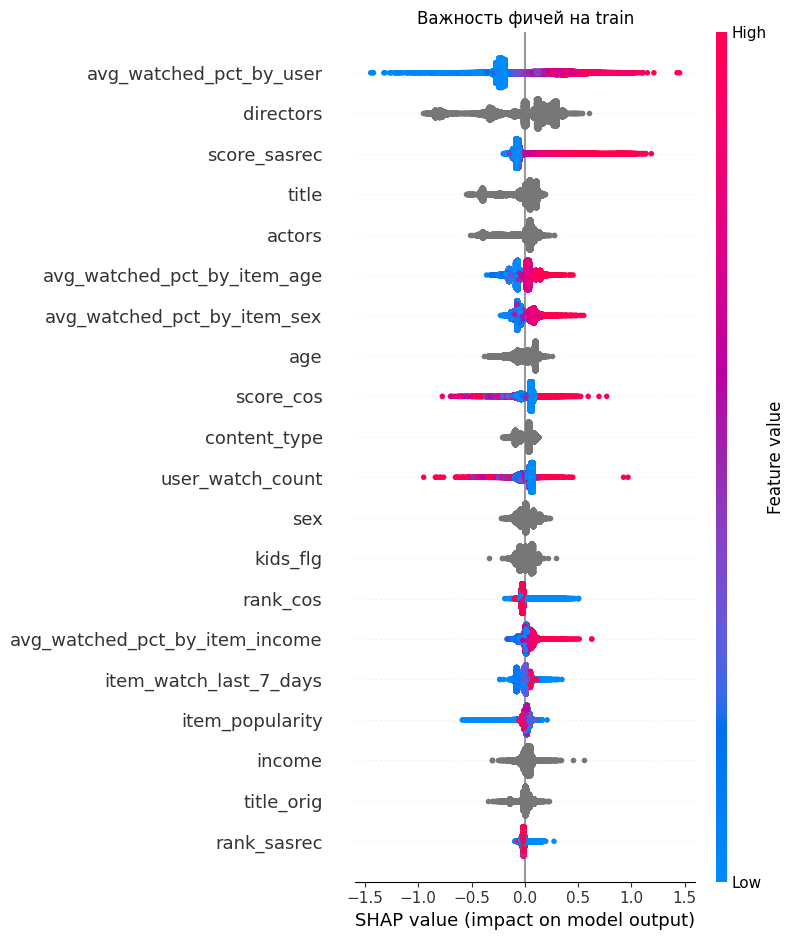

In [85]:
plt.title("Важность фичей на train")

shap.summary_plot(
    shap_values,
    X_train_subs
)

все-таки решила убрать фичу awg_watched_pct, и стало лучше

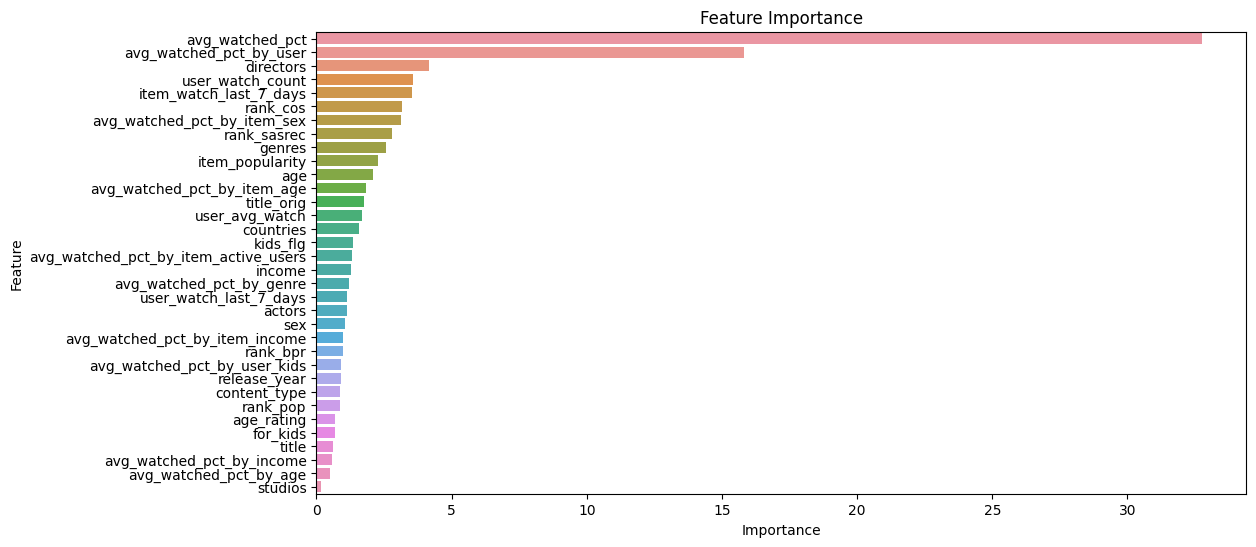

In [201]:
feature_importance = ctb_model.get_feature_importance()

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Визуализация
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

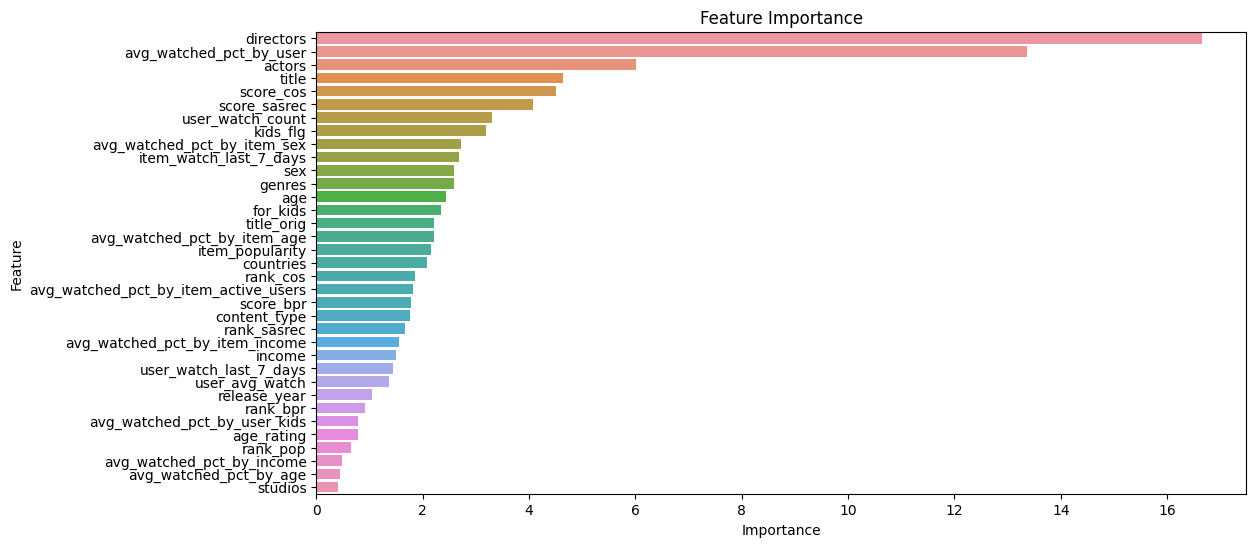

In [86]:
feature_importance = ctb_model.get_feature_importance()

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Визуализация
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [87]:
from catboost import CatBoostRanker, Pool
import pandas as pd

In [88]:
# Параметры для обучения
est_params = {
    'max_depth': 6,
    'iterations': 1000,  
    'learning_rate': 0.1,
    'random_state': 42,
    'verbose': 200,
    'eval_metric': 'NDCG', 
    'loss_function': 'YetiRank'
}

ctb_ranker = CatBoostRanker(**est_params, task_type='GPU')

train_for_boost = train_for_boost.sort_values('user_id')

X = train_for_boost.drop(columns=['target', 'user_id', 'item_id'])
y = train_for_boost['target']
group_id = train_for_boost['user_id']

unique_users = train_for_boost['user_id'].unique()
train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)

train_data = train_for_boost[train_for_boost['user_id'].isin(train_users)]
test_data = train_for_boost[train_for_boost['user_id'].isin(test_users)]

X_train = train_data.drop(columns=['target', 'user_id', 'item_id'])
y_train = train_data['target']
group_id_train = train_data['user_id']

X_test = test_data.drop(columns=['target', 'user_id', 'item_id'])
y_test = test_data['target']
group_id_test = test_data['user_id']

for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

train_pool = Pool(
    data=X_train,
    label=y_train,
    group_id=group_id_train,
    cat_features=cat_features
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    group_id=group_id_test,
    cat_features=cat_features
)

In [89]:
ctb_ranker.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=100
)

Groupwise loss function. OneHotMaxSize set to 10


Default metric period is 5 because PFound, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.9630442	best: 0.9630442 (0)	total: 128ms	remaining: 2m 7s
200:	test: 0.9717122	best: 0.9717122 (200)	total: 14s	remaining: 55.7s
400:	test: 0.9718804	best: 0.9718946 (396)	total: 28.4s	remaining: 42.5s
bestTest = 0.9719423324
bestIteration = 438
Shrink model to first 439 iterations.


In [90]:
ctb_ranker.save_model('/kaggle/working/catboost_model_ranker.cbm')  

In [91]:
# сэмплируем для shap_values
X_train_subs, _, y_train_subs, __ = train_test_split(X_train, y_train,
                                                     test_size=0.9,
                                                     random_state=42)
for col in cat_features:
    X_train_subs[col] = X_train_subs[col].astype(str)

shap_values = ctb_ranker.get_feature_importance(Pool(X_train_subs, y_train_subs, cat_features=cat_features), type='ShapValues')

expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]

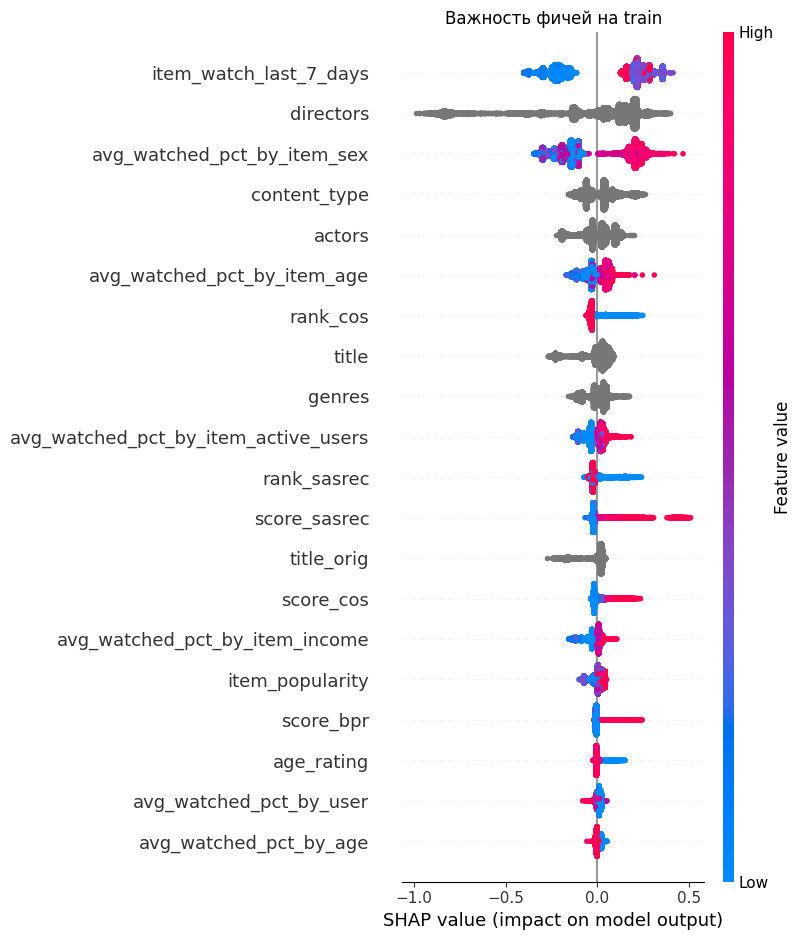

In [92]:
plt.title("Важность фичей на train")

shap.summary_plot(
    shap_values,
    X_train_subs
)

In [93]:
test = pd.read_csv('/kaggle/input/recasts-hw3/test_part.csv')
test.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,718866,6382,2021-08-13,10309,19.0,0
1,147119,13865,2021-08-13,1666,26.0,0
2,1079425,4141,2021-08-13,774,10.0,0
3,810008,15297,2021-08-13,3,0.0,0
4,1068123,10440,2021-08-13,492,0.0,0


In [100]:
test.shape

(608467, 6)

In [94]:
test_hot = test[test['user_id'].isin(cands_train['user_id'].unique())]
test_cold = test[~test['user_id'].isin(cands_train['user_id'].unique())]

In [110]:
test_hot.shape

(204026, 6)

In [111]:
test_cold.shape

(404441, 6)

In [95]:
items = pd.read_csv('/kaggle/input/recasts-hw3/items-2.csv')
items.drop(columns=['description', 'keywords'], inplace=True)
users = pd.read_csv('/kaggle/input/recasts-hw3/users.csv')

In [101]:
users = create_user_features(users, train_data)
items = create_item_features(items, train_data)

In [102]:
mapper_cos = generate_implicit_recs_mapper(cosine_model, train_mat, 20, users_mapping, items_inv_mapping)

In [103]:
mapper_bpr = generate_implicit_recs_mapper(bpr_model, train_mat, 20, users_mapping, items_inv_mapping)

In [104]:
knn_prediction = pd.DataFrame({'user_id': test_hot['user_id'].unique()})
knn_prediction['item_score'] = knn_prediction['user_id'].map(mapper_cos)
knn_prediction = knn_prediction.explode('item_score')
knn_prediction[['item_id', 'score']] = pd.DataFrame(knn_prediction['item_score'].tolist(), index=knn_prediction.index)
knn_prediction['rank'] = knn_prediction.groupby('user_id').cumcount() + 1
knn_prediction = knn_prediction[['user_id', 'item_id', 'score', 'rank']]
knn_prediction

,user_id,item_id,score,rank
0,904831,4151,1.058772,1
0,904831,13865,0.981198,2
0,904831,142,0.925190,3
0,904831,4880,0.903506,4
0,904831,3553,0.834771,5
...,...,...,...,...
70824,1035030,15531,0.166987,16
70824,1035030,7545,0.159782,17
70824,1035030,15096,0.158155,18
70824,1035030,11345,0.154943,19


In [112]:
knn_prediction = pd.DataFrame({'user_id': test_hot['user_id'].unique()})
knn_prediction['item_id'] = knn_prediction['user_id'].map(mapper_cos)
knn_prediction = knn_prediction.explode('item_id')
knn_prediction['rank'] = knn_prediction.groupby('user_id').cumcount() + 1
knn_prediction

,user_id,item_id,rank
0,904831,4151,1
0,904831,13865,2
0,904831,142,3
0,904831,4880,4
0,904831,3553,5
...,...,...,...
70824,1035030,15531,16
70824,1035030,7545,17
70824,1035030,15096,18
70824,1035030,11345,19


In [105]:
bpr_prediction = pd.DataFrame({'user_id': test_hot['user_id'].unique()})
bpr_prediction['item_score'] = bpr_prediction['user_id'].map(mapper_bpr)
bpr_prediction = bpr_prediction.explode('item_score')
bpr_prediction[['item_id', 'score']] = pd.DataFrame(bpr_prediction['item_score'].tolist(), index=bpr_prediction.index)
bpr_prediction['rank'] = bpr_prediction.groupby('user_id').cumcount() + 1
bpr_prediction = bpr_prediction[['user_id', 'item_id', 'score', 'rank']]
bpr_prediction

,user_id,item_id,score,rank
0,904831,8337,3.727148,1
0,904831,16479,3.565489,2
0,904831,1737,3.515134,3
0,904831,170,3.479902,4
0,904831,10020,3.384166,5
...,...,...,...,...
70824,1035030,9812,2.036748,16
70824,1035030,14598,2.030564,17
70824,1035030,3296,2.022851,18
70824,1035030,8822,2.018954,19


In [113]:
bpr_prediction = pd.DataFrame({'user_id': test_hot['user_id'].unique()})
bpr_prediction['item_id'] = bpr_prediction['user_id'].map(mapper_bpr)
bpr_prediction = bpr_prediction.explode('item_id')
bpr_prediction['rank'] = bpr_prediction.groupby('user_id').cumcount() + 1
bpr_prediction

,user_id,item_id,rank
0,904831,8337,1
0,904831,1737,2
0,904831,10020,3
0,904831,2912,4
0,904831,16479,5
...,...,...,...
70824,1035030,13589,16
70824,1035030,3113,17
70824,1035030,12202,18
70824,1035030,5138,19


In [106]:
sasrec_prediction = sasrec.recommend(
    users=test_hot['user_id'].unique(),  
    dataset=dataset,
    k=20,
    filter_viewed=True,
    on_unsupported_targets="warn"
)
# sasrec_prediction.drop(columns=['score'], inplace=True)
sasrec_prediction

,user_id,item_id,score,rank
0,904831,9728,3.486895,1
1,904831,4151,3.399143,2
2,904831,13865,3.219043,3
3,904831,2657,3.203600,4
4,904831,6382,2.819326,5
...,...,...,...,...
1416315,1035030,8822,1.395023,16
1416316,1035030,7107,1.330209,17
1416317,1035030,5250,1.326504,18
1416318,1035030,9996,1.308066,19


In [107]:
pop_prediction = pd.DataFrame({'user_id': test['user_id'].unique()})
pop_prediction['item_id'] = pop_model.recommend(pop_prediction['user_id'], N=20)
pop_prediction = pop_prediction.explode('item_id')
pop_prediction['rank'] = pop_prediction.groupby('user_id').cumcount() + 1
pop_prediction

,user_id,item_id,rank
0,718866,10440,1
0,718866,15297,2
0,718866,13865,3
0,718866,9728,4
0,718866,2657,5
...,...,...,...
216398,1035030,7571,16
216398,1035030,14431,17
216398,1035030,1132,18
216398,1035030,8636,19


In [108]:
pop_prediction = pop_prediction.rename(columns={'rank': 'rank_pop'})
knn_prediction = knn_prediction.rename(columns={'rank': 'rank_cos'})
bpr_prediction = bpr_prediction.rename(columns={'rank': 'rank_bpr'})
sasrec_prediction = sasrec_prediction.rename(columns={'rank': 'rank_sasrec'})

knn_prediction = knn_prediction.rename(columns={'score': 'score_cos'})
bpr_prediction = bpr_prediction.rename(columns={'score': 'score_bpr'})
sasrec_prediction = sasrec_prediction.rename(columns={'score': 'score_sasrec'})

test_merged_recs = pop_prediction.merge(knn_prediction, on=['user_id', 'item_id'], how='outer')
test_merged_recs = test_merged_recs.merge(bpr_prediction, on=['user_id', 'item_id'], how='outer')
test_merged_recs = test_merged_recs.merge(sasrec_prediction, on=['user_id', 'item_id'], how='outer')

In [109]:
cols_to_fill = ['rank_pop', 'rank_cos', 'rank_bpr', 'rank_sasrec'] 
test_merged_recs[cols_to_fill] = test_merged_recs[cols_to_fill].fillna(10000)
cols_to_fill = ['score_cos', 'score_bpr', 'score_sasrec'] 
test_merged_recs[cols_to_fill] = test_merged_recs[cols_to_fill].fillna(0)

In [117]:
test_merged_recs.fillna(10000, inplace=True)

In [110]:
test_merged_recs

,user_id,item_id,rank_pop,score_cos,rank_cos,score_bpr,rank_bpr,score_sasrec,rank_sasrec
0,1,142,9.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
1,1,1132,18.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
2,1,1844,14.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
3,1,2657,5.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
4,1,3734,6.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
...,...,...,...,...,...,...,...,...,...
6609253,1097549,10440,1.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
6609254,1097549,12995,8.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
6609255,1097549,13865,3.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
6609256,1097549,14431,17.0,0.0,10000.0,0.0,10000.0,0.0,10000.0


In [111]:
test_for_boost = test_merged_recs.merge(users, 
                      on=['user_id'],
                      how='left')
test_for_boost = test_for_boost.merge(items, 
                      on=['item_id'],
                      how='left')
test_for_boost.head()

,user_id,item_id,rank_pop,score_cos,rank_cos,score_bpr,rank_bpr,score_sasrec,rank_sasrec,age,...,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,item_popularity,item_watch_last_7_days
0,1,142,9.0,0.0,10000.0,0.0,10000.0,0.0,10000.0,age_25_34,...,2020.0,"драмы, триллеры",Россия,NaN,16.0,NaN,Анастасия Пальчикова,"Максим Суханов, Аня Чиповская, Полина Гухман, ...",41817.0,2299.0
1,1,1132,18.0,0.0,10000.0,0.0,10000.0,0.0,10000.0,age_25_34,...,2020.0,"драмы, комедии",Франция,NaN,16.0,NaN,Жан-Поль Саломе,"Изабель Юппер, Ипполит Жирардо, Фарида Ушани, ...",10763.0,495.0
2,1,1844,14.0,0.0,10000.0,0.0,10000.0,0.0,10000.0,age_25_34,...,2020.0,"триллеры, комедии",Великобритания,NaN,18.0,NaN,Джей Блейксон,"Розамунд Пайк, Питер Динклэйдж, Эйса Гонсалес,...",23783.0,481.0
3,1,2657,5.0,0.0,10000.0,0.0,10000.0,0.0,10000.0,age_25_34,...,2021.0,"драмы, триллеры",Россия,NaN,16.0,NaN,Илья Куликов,"Александр Hовиков, Валентина Ляпина, Никита Па...",65273.0,3987.0
4,1,3734,6.0,0.0,10000.0,0.0,10000.0,0.0,10000.0,age_25_34,...,2021.0,комедии,Россия,NaN,16.0,NaN,Марюс Вайсберг,"Александр Ревва, Глюкоза, Дмитрий Нагиев, Миха...",67410.0,5599.0


In [112]:
test_for_boost.shape

(6609258, 31)

In [113]:
import gc

gc.collect()

5

In [114]:
test_for_boost = create_interaction_features(train_data, users, items, test_for_boost)

In [115]:
cat_f = ['age', 'income', 'sex', 'kids_flg', 'title_orig', 'for_kids', 'studios', 'directors', 'actors']
for feature in cat_f:
    test_for_boost[feature].fillna(f'{feature}_unknown', inplace=True)
    
n_f = ['avg_watched_pct_by_age', 'avg_watched_pct_by_income', 'user_avg_watch', 'user_watch_count', 'user_watch_last_7_days', 'item_watch_last_7_days', 'avg_watched_pct_by_item_sex', 'avg_watched_pct_by_item_age', 'avg_watched_pct_by_item_income', 'avg_watched_pct_by_user_kids', 'avg_watched_pct_by_user', 'avg_watched_pct_by_item_active_users']
for feature in n_f:
    test_for_boost[feature].fillna(0, inplace=True)

In [116]:
test_for_boost.head(2)

,user_id,item_id,rank_pop,score_cos,rank_cos,score_bpr,rank_bpr,score_sasrec,rank_sasrec,age,...,directors,actors,item_popularity,item_watch_last_7_days,avg_watched_pct_by_item_sex,avg_watched_pct_by_item_age,avg_watched_pct_by_item_income,avg_watched_pct_by_user_kids,avg_watched_pct_by_user,avg_watched_pct_by_item_active_users
0,1,142,9.0,0.0,10000.0,0.0,10000.0,0.0,10000.0,age_25_34,...,Анастасия Пальчикова,"Максим Суханов, Аня Чиповская, Полина Гухман, ...",41817.0,2299.0,62.749614,62.597452,61.161811,0.0,0.0,61.221676
1,1,1132,18.0,0.0,10000.0,0.0,10000.0,0.0,10000.0,age_25_34,...,Жан-Поль Саломе,"Изабель Юппер, Ипполит Жирардо, Фарида Ушани, ...",10763.0,495.0,39.708038,39.336409,37.598097,0.0,0.0,38.034870


In [117]:
for col in cat_features:
    test_for_boost[col] = test_for_boost[col].astype(str)
    test_for_boost[col] = test_for_boost[col].astype(str)

In [118]:
test_for_boost[FEATURES]

,rank_pop,score_cos,rank_cos,score_bpr,rank_bpr,score_sasrec,rank_sasrec,age,income,sex,...,directors,actors,item_popularity,item_watch_last_7_days,avg_watched_pct_by_item_sex,avg_watched_pct_by_item_age,avg_watched_pct_by_item_income,avg_watched_pct_by_user_kids,avg_watched_pct_by_user,avg_watched_pct_by_item_active_users
0,9.0,0.0,10000.0,0.0,10000.0,0.0,10000.0,age_25_34,income_20_40,Ж,...,Анастасия Пальчикова,"Максим Суханов, Аня Чиповская, Полина Гухман, ...",41817.0,2299.0,62.749614,62.597452,61.161811,0.0,0.0,61.221676
1,18.0,0.0,10000.0,0.0,10000.0,0.0,10000.0,age_25_34,income_20_40,Ж,...,Жан-Поль Саломе,"Изабель Юппер, Ипполит Жирардо, Фарида Ушани, ...",10763.0,495.0,39.708038,39.336409,37.598097,0.0,0.0,38.034870
2,14.0,0.0,10000.0,0.0,10000.0,0.0,10000.0,age_25_34,income_20_40,Ж,...,Джей Блейксон,"Розамунд Пайк, Питер Динклэйдж, Эйса Гонсалес,...",23783.0,481.0,61.134336,60.746705,58.065314,0.0,0.0,56.558966
3,5.0,0.0,10000.0,0.0,10000.0,0.0,10000.0,age_25_34,income_20_40,Ж,...,Илья Куликов,"Александр Hовиков, Валентина Ляпина, Никита Па...",65273.0,3987.0,17.373945,15.684463,16.557533,0.0,0.0,16.368515
4,6.0,0.0,10000.0,0.0,10000.0,0.0,10000.0,age_25_34,income_20_40,Ж,...,Марюс Вайсберг,"Александр Ревва, Глюкоза, Дмитрий Нагиев, Миха...",67410.0,5599.0,71.311919,71.857364,71.386343,0.0,0.0,70.944383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6609253,1.0,0.0,10000.0,0.0,10000.0,0.0,10000.0,age_25_34,income_40_60,Ж,...,Душан Глигоров,"Антон Васильев, Николай Шрайбер, Екатерина Оль...",184054.0,17174.0,49.571433,48.598427,48.280643,0.0,0.0,45.448980
6609254,8.0,0.0,10000.0,0.0,10000.0,0.0,10000.0,age_25_34,income_40_60,Ж,...,Гуань Ху,"Ван Цяньюань, Цзян У, Хуан Чжичжун, Чжан Цзюнъ...",21350.0,562.0,39.112130,42.323138,42.036039,0.0,0.0,39.228227
6609255,3.0,0.0,10000.0,0.0,10000.0,0.0,10000.0,age_25_34,income_40_60,Ж,...,Тимур Бекмамбетов,"Павел Прилучный, Павел Чинарёв, Тимофей Трибун...",111863.0,6132.0,65.790149,67.068682,68.582987,0.0,0.0,66.527800
6609256,17.0,0.0,10000.0,0.0,10000.0,0.0,10000.0,age_25_34,income_40_60,Ж,...,Святослав Подгаевский,"Яна Енжаева, Константин Белошапка, Илья Ермоло...",20012.0,673.0,60.734886,56.674955,54.675751,0.0,0.0,54.592161


In [119]:
ctb_prediction = ctb_model.predict_proba(test_for_boost[FEATURES])

In [120]:
ctb_prediction_ranker = ctb_ranker.predict(test_for_boost[FEATURES])

In [121]:
ctb_prediction.shape

(6609258, 2)

In [122]:
ctb_prediction_ranker.shape

(6609258,)

In [123]:
final_prediction_catboost = test_for_boost[['user_id', 'item_id']]

In [124]:
final_prediction_catboost_ranker = test_for_boost[['user_id', 'item_id']]

In [125]:
final_prediction_catboost['ctb_pred'] = ctb_prediction[:, 1]
final_prediction_catboost.head()

,user_id,item_id,ctb_pred
0,1,142,0.500351
1,1,1132,0.299697
2,1,1844,0.576482
3,1,2657,0.050325
4,1,3734,0.630394


In [126]:
final_prediction_catboost_ranker['ctb_pred'] = ctb_prediction_ranker
final_prediction_catboost_ranker.head()

,user_id,item_id,ctb_pred
0,1,142,0.107162
1,1,1132,-0.756998
2,1,1844,0.373642
3,1,2657,-2.488200
4,1,3734,0.571489


In [127]:
final_prediction_catboost.sort_values(
    by=['user_id'], ascending=[True]).head(10)

,user_id,item_id,ctb_pred
3,1,2657,0.050325
4,1,3734,0.630394
5,1,3935,0.469905
6,1,4151,0.293264
7,1,4457,0.442082
8,1,4740,0.307906
9,1,4880,0.052424
10,1,7102,0.313207
11,1,7571,0.479064
12,1,8636,0.586570


In [128]:
final_prediction_catboost_ranker.sort_values(
    by=['user_id'], ascending=[True]).head(10)

,user_id,item_id,ctb_pred
3,1,2657,-2.488200
4,1,3734,0.571489
5,1,3935,0.060651
6,1,4151,-0.794021
7,1,4457,-0.034682
8,1,4740,-0.696237
9,1,4880,-2.445161
10,1,7102,-0.488975
11,1,7571,0.088080
12,1,8636,0.513375


In [129]:
# сортируем по скору внутри одного пользователя и проставляем новый ранг
final_prediction_catboost = final_prediction_catboost.sort_values(
    by=['user_id', 'ctb_pred'], ascending=[True, False])
final_prediction_catboost['rank_ctb'] = final_prediction_catboost.groupby('user_id').cumcount() + 1

In [130]:
final_prediction_catboost_ranker = final_prediction_catboost_ranker.sort_values(
    by=['user_id', 'ctb_pred'], ascending=[True, False])
final_prediction_catboost_ranker['rank_ctb'] = final_prediction_catboost_ranker.groupby('user_id').cumcount() + 1

In [131]:
final_prediction_catboost_ranker.head()

,user_id,item_id,ctb_pred,rank_ctb
19,1,15297,0.673524,1
13,1,9728,0.650859,2
4,1,3734,0.571489,3
12,1,8636,0.513375,4
17,1,13865,0.511172,5


In [132]:
def compute_metrics(df_true, df_pred, top_N, rank_col='rank'):
    result = {}
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', rank_col])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')[rank_col].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs[rank_col]).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs[rank_col]
    
    users_count = test_recs.index.get_level_values('user_id').nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs[rank_col] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    result[f'MRR'] = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
    return pd.Series(result)

In [133]:
test = test[['user_id', 'item_id', 'target']]

In [134]:
test_try = test[test['target'] == 1]

In [135]:
metrics = compute_metrics(test_try[['user_id', 'item_id']],
                              final_prediction_catboost, 
                              top_N=10,
                              rank_col='rank_ctb')
metrics

Precision@1     0.053647
Recall@1        0.034848
Precision@2     0.048184
Recall@2        0.061661
Precision@3     0.037743
Recall@3        0.071523
Precision@4     0.033934
Recall@4        0.084670
Precision@5     0.031683
Recall@5        0.098552
Precision@6     0.030933
Recall@6        0.115737
Precision@7     0.030931
Recall@7        0.135553
Precision@8     0.029539
Recall@8        0.147695
Precision@9     0.028421
Recall@9        0.159791
Precision@10    0.028793
Recall@10       0.182174
MAP@10          0.078871
MRR             0.110651
dtype: float64

In [136]:
metrics_rank = compute_metrics(test_try[['user_id', 'item_id']],
                              final_prediction_catboost_ranker, 
                              top_N=10,
                              rank_col='rank_ctb')
metrics_rank

Precision@1     0.087625
Recall@1        0.059924
Precision@2     0.072866
Recall@2        0.099470
Precision@3     0.061579
Recall@3        0.124299
Precision@4     0.053960
Recall@4        0.142992
Precision@5     0.048522
Recall@5        0.158611
Precision@6     0.043584
Recall@6        0.170202
Precision@7     0.042045
Recall@7        0.194336
Precision@8     0.040179
Recall@8        0.213245
Precision@9     0.037904
Recall@9        0.225879
Precision@10    0.035206
Recall@10       0.232100
MAP@10          0.112691
MRR             0.153589
dtype: float64

In [137]:
metrics_pop = compute_metrics(test_try[['user_id', 'item_id']],
                              pop_prediction, 
                              top_N=10,
                              rank_col='rank_pop')
metrics_pop

Precision@1     0.067662
Recall@1        0.052643
Precision@2     0.068587
Recall@2        0.105141
Precision@3     0.063356
Recall@3        0.138563
Precision@4     0.067521
Recall@4        0.189744
Precision@5     0.054408
Recall@5        0.191261
Precision@6     0.052610
Recall@6        0.217748
Precision@7     0.048007
Recall@7        0.231606
Precision@8     0.042447
Recall@8        0.233247
Precision@9     0.039359
Recall@9        0.241066
Precision@10    0.035600
Recall@10       0.242276
MAP@10          0.116423
MRR             0.146444
dtype: float64

In [138]:
df_metrics = pd.concat([
    pd.DataFrame(metrics_pop).transpose(),
    pd.DataFrame(metrics).transpose(),
    pd.DataFrame(metrics_rank).transpose(),
    
])

df_metrics.index = ['TopPop', 'model_2step', 'model_2step_rank']

df_metrics

,Precision@1,Recall@1,Precision@2,Recall@2,Precision@3,Recall@3,Precision@4,Recall@4,Precision@5,Recall@5,...,Precision@7,Recall@7,Precision@8,Recall@8,Precision@9,Recall@9,Precision@10,Recall@10,MAP@10,MRR
TopPop,0.067662,0.052643,0.068587,0.105141,0.063356,0.138563,0.067521,0.189744,0.054408,0.191261,...,0.048007,0.231606,0.042447,0.233247,0.039359,0.241066,0.035600,0.242276,0.116423,0.146444
model_2step,0.053647,0.034848,0.048184,0.061661,0.037743,0.071523,0.033934,0.084670,0.031683,0.098552,...,0.030931,0.135553,0.029539,0.147695,0.028421,0.159791,0.028793,0.182174,0.078871,0.110651
model_2step_rank,0.087625,0.059924,0.072866,0.099470,0.061579,0.124299,0.053960,0.142992,0.048522,0.158611,...,0.042045,0.194336,0.040179,0.213245,0.037904,0.225879,0.035206,0.232100,0.112691,0.153589


In [139]:
import matplotlib.pyplot as plt

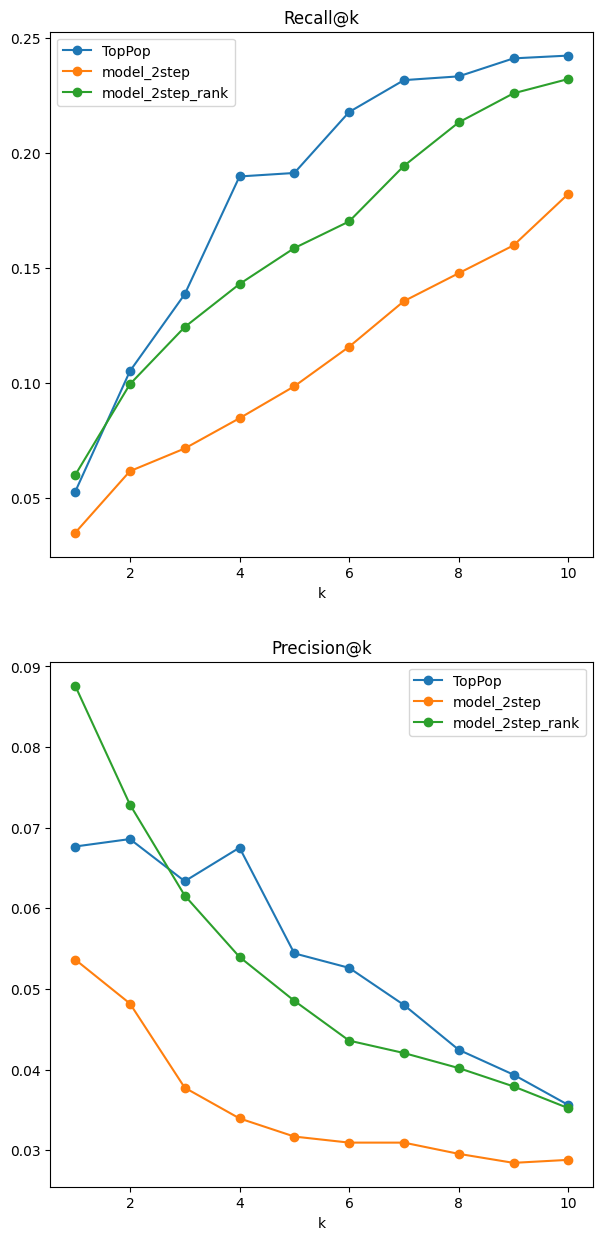

In [140]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(7, 15))

for indx, metric in enumerate([f'Recall@', f'Precision@']):
    for model in df_metrics.index:
        axes[indx].plot(range(1, 11), 
                        df_metrics.loc[model][[metric+f'{k}' for k in range(1, 11)]].values,
                        label=model, marker='o')
        axes[indx].legend()
        axes[indx].set_title(f'{metric}k')
        axes[indx].set_xlabel('k')


## 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

In [141]:
train_data = pd.read_csv('/kaggle/input/recasts-hw3/train_part.csv')
test = pd.read_csv('/kaggle/input/recasts-hw3/test_part.csv')

train_data['last_watch_dt'] = pd.to_datetime(train_data['last_watch_dt'], format = '%Y-%m-%d')
test['last_watch_dt'] = pd.to_datetime(test['last_watch_dt'], format = '%Y-%m-%d')

memory_optimize(train_data, name='user_id')
memory_optimize(train_data, name='item_id')
memory_optimize(train_data, name='total_dur')

memory_optimize(test, name='user_id')
memory_optimize(test, name='item_id')
memory_optimize(test, name='total_dur')

train_test = pd.concat([train_data, test])

In [96]:
train_test

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,2021-03-13,4485,98.0,1
1,952323,15997,2021-03-13,7507,100.0,1
2,889459,11460,2021-03-13,60,0.0,0
3,854016,11237,2021-03-13,5381,98.0,1
4,307257,9132,2021-03-13,5814,100.0,1
...,...,...,...,...,...,...
608462,1035030,10201,2021-08-22,1154,19.0,0
608463,574452,2720,2021-08-22,9076,5.0,0
608464,700990,13865,2021-08-22,9010,100.0,1
608465,693510,7571,2021-08-22,3697,64.0,1


In [142]:
users_inv_mapping = dict(enumerate(train_test['user_id'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}
print(len(users_mapping))
items_inv_mapping = dict(enumerate(train_test['item_id'].unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}
print(len(items_mapping))

962151
15605


In [143]:
def get_coo_matrix(df,
                   user_col='user_id',
                   item_col='item_id',
                   weight_col=None,
                   users_mapping=users_mapping,
                   items_mapping=items_mapping):
    if weight_col is None:
        weights = np.ones(len(df), dtype=np.float32)
    else:
        weights = df[weight_col].astype(np.float32)

    interaction_matrix = sp.coo_matrix((
        weights,
        (
            df[user_col].map(users_mapping.get),
            df[item_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix

In [144]:
train_mat = get_coo_matrix(train_test)
train_mat = train_mat.tocsr()
train_mat

<962151x15605 sparse matrix of type '<class 'numpy.float32'>'
	with 5475423 stored elements in Compressed Sparse Row format>

In [145]:
cosine_model = CosineRecommender(K=5000)
cosine_model.fit(train_mat)

bpr_model = BayesianPersonalizedRanking()
bpr_model.fit(train_mat)

  0%|          | 0/15605 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

разрешили инференсить на подвыборке юзеров, тк не влезает в память

In [146]:
import numpy as np

unique_users = train_test['user_id'].unique()
sample_size = int(len(unique_users) * 0.2)  
sampled_users = np.random.choice(unique_users, size=sample_size, replace=False)

взяла от каждой модели по 10 реков опять-таки из-за рама

In [147]:
mapper_cos = generate_implicit_recs_mapper(cosine_model, train_mat, 10, users_mapping, items_inv_mapping)
mapper_bpr = generate_implicit_recs_mapper(bpr_model, train_mat, 10, users_mapping, items_inv_mapping)

recs_cos = pd.DataFrame({'user_id': cands_pred_hot['user_id'].unique()})
recs_cos['item_score'] = recs_cos['user_id'].map(mapper_cos)
recs_cos = recs_cos.explode('item_score')
recs_cos[['item_id', 'score']] = pd.DataFrame(recs_cos['item_score'].tolist(), index=recs_cos.index)
recs_cos['rank'] = recs_cos.groupby('user_id').cumcount() + 1
recs_cos = recs_cos[['user_id', 'item_id', 'score', 'rank']]

recs_bpr = pd.DataFrame({'user_id': cands_pred_hot['user_id'].unique()})
recs_bpr['item_score'] = recs_bpr['user_id'].map(mapper_bpr)
recs_bpr = recs_bpr.explode('item_score')
recs_bpr[['item_id', 'score']] = pd.DataFrame(recs_bpr['item_score'].tolist(), index=recs_bpr.index)
recs_bpr['rank'] = recs_bpr.groupby('user_id').cumcount() + 1
recs_bpr = recs_bpr[['user_id', 'item_id', 'score', 'rank']]

In [148]:
interactions = (
    pd.read_csv('/kaggle/input/recasts-hw3/train_part.csv', parse_dates=["last_watch_dt"])
    .rename(columns={"last_watch_dt": Columns.Datetime})
)

test = (
    pd.read_csv('/kaggle/input/recasts-hw3/test_part.csv', parse_dates=["last_watch_dt"])
    .rename(columns={"last_watch_dt": Columns.Datetime})
)

interactions = pd.concat([interactions, test])

# Process interactions
interactions[Columns.Weight] = 1
interactions = interactions[["user_id", "item_id", "datetime", "weight"]]
print(interactions.shape)
interactions.head(2)

(5475423, 4)


,user_id,item_id,datetime,weight
0,310745,13373,2021-03-13,1
1,952323,15997,2021-03-13,1


In [149]:
dataset = Dataset.construct(
    interactions_df=interactions,
)

sasrec = SASRecModel(
    session_max_len=20,
    loss="softmax",
    n_factors=64,
    n_blocks=1,
    n_heads=4,
    dropout_rate=0.2,
    lr=0.001,
    batch_size=128,
    epochs=1,
    verbose=1,
    deterministic=True,
)

sasrec.fit(dataset);

Training: |          | 0/? [00:00<?, ?it/s]

In [150]:
recs_df = sasrec.recommend(
    users=sampled_users,  
    dataset=dataset,
    k=10,
    filter_viewed=True,
    on_unsupported_targets="warn"
)
recs_df

,user_id,item_id,score,rank
0,1032671,15297,5.070934,1
1,1032671,10440,4.304198,2
2,1032671,4151,3.563979,3
3,1032671,13865,3.469202,4
4,1032671,9728,3.392386,5
...,...,...,...,...
1923985,562175,12192,2.409235,6
1923986,562175,4151,2.319806,7
1923987,562175,5732,2.167664,8
1923988,562175,7793,1.992105,9


In [151]:
pop_model = PopularRecommender(days=30, dt_column='last_watch_dt')
pop_model.fit(train_test)

recs_pop = pd.DataFrame({'user_id': sampled_users})
recs_pop['item_id'] = pop_model.recommend(recs_pop['user_id'], N=10)
recs_pop = recs_pop.explode('item_id')
recs_pop['rank'] = recs_pop.groupby('user_id').cumcount() + 1

recs_pop = recs_pop.rename(columns={'rank': 'rank_pop'})
recs_cos = recs_cos.rename(columns={'rank': 'rank_cos'})
recs_bpr = recs_bpr.rename(columns={'rank': 'rank_bpr'})
recs_df = recs_df.rename(columns={'rank': 'rank_sasrec'})

recs_cos = recs_cos.rename(columns={'score': 'score_cos'})
recs_bpr = recs_bpr.rename(columns={'score': 'score_bpr'})
recs_df = recs_df.rename(columns={'score': 'score_sasrec'})

merged_recs = recs_pop.merge(recs_cos, on=['user_id', 'item_id'], how='outer')
merged_recs = merged_recs.merge(recs_bpr, on=['user_id', 'item_id'], how='outer')
merged_recs = merged_recs.merge(recs_df, on=['user_id', 'item_id'], how='outer')

cols_to_fill = ['rank_pop', 'rank_cos', 'rank_bpr', 'rank_sasrec'] 
merged_recs[cols_to_fill] = merged_recs[cols_to_fill].fillna(10000)
cols_to_fill = ['score_cos', 'score_bpr', 'score_sasrec'] 
merged_recs[cols_to_fill] = merged_recs[cols_to_fill].fillna(0)

In [152]:
merged_recs

,user_id,item_id,rank_pop,score_cos,rank_cos,score_bpr,rank_bpr,score_sasrec,rank_sasrec
0,3,861,10000.0,0.000000,10000.0,2.064467,7.0,0.000000,10000.0
1,3,2816,10000.0,0.000000,10000.0,2.135307,6.0,0.000000,10000.0
2,3,3363,10000.0,0.000000,10000.0,2.049860,9.0,0.000000,10000.0
3,3,4495,10000.0,1.749909,7.0,0.000000,10000.0,0.000000,10000.0
4,3,4689,10000.0,0.000000,10000.0,2.139590,5.0,0.000000,10000.0
...,...,...,...,...,...,...,...,...,...
5994320,1097555,10440,1.0,0.000000,10000.0,0.000000,10000.0,3.349117,2.0
5994321,1097555,11863,8.0,0.000000,10000.0,0.000000,10000.0,1.517436,10.0
5994322,1097555,12192,6.0,0.000000,10000.0,0.000000,10000.0,2.007038,7.0
5994323,1097555,13865,4.0,0.000000,10000.0,0.000000,10000.0,3.074205,3.0


In [153]:
items = pd.read_csv('/kaggle/input/recasts-hw3/items-2.csv')
items.drop(columns=['description', 'keywords'], inplace=True)
users = pd.read_csv('/kaggle/input/recasts-hw3/users.csv')

In [154]:
users = create_user_features(users, train_test)
items = create_item_features(items, train_test)

In [155]:
test_for_boost = merged_recs.merge(users, 
                      on=['user_id'],
                      how='left')
test_for_boost = test_for_boost.merge(items, 
                      on=['item_id'],
                      how='left')

In [156]:
test_for_boost = create_interaction_features(train_test, users, items, test_for_boost)

In [157]:
FEATURES

Index(['rank_pop', 'score_cos', 'rank_cos', 'score_bpr', 'rank_bpr',
       'score_sasrec', 'rank_sasrec', 'age', 'income', 'sex', 'kids_flg',
       'avg_watched_pct_by_age', 'avg_watched_pct_by_income', 'user_avg_watch',
       'user_watch_count', 'user_watch_last_7_days', 'content_type', 'title',
       'title_orig', 'release_year', 'genres', 'countries', 'for_kids',
       'age_rating', 'studios', 'directors', 'actors', 'item_popularity',
       'item_watch_last_7_days', 'avg_watched_pct_by_item_sex',
       'avg_watched_pct_by_item_age', 'avg_watched_pct_by_item_income',
       'avg_watched_pct_by_user_kids', 'avg_watched_pct_by_user',
       'avg_watched_pct_by_item_active_users'],
      dtype='object')

In [158]:
cat_f = ['age', 'income', 'sex', 'kids_flg', 'title_orig', 'for_kids', 'studios', 'directors', 'actors']
for feature in cat_f:
    test_for_boost[feature].fillna(f'{feature}_unknown', inplace=True)
    
n_f = ['avg_watched_pct_by_age', 'avg_watched_pct_by_income', 'user_avg_watch', 'user_watch_count', 'user_watch_last_7_days', 'item_watch_last_7_days', 'avg_watched_pct_by_item_sex', 'avg_watched_pct_by_item_age', 'avg_watched_pct_by_item_income', 'avg_watched_pct_by_user_kids', 'avg_watched_pct_by_user', 'avg_watched_pct_by_item_active_users']
for feature in n_f:
    test_for_boost[feature].fillna(0, inplace=True)

for col in cat_features:
    test_for_boost[col] = test_for_boost[col].astype(str)
    test_for_boost[col] = test_for_boost[col].astype(str)

In [159]:
from catboost import CatBoostRanker

ctb_ranker_loaded = CatBoostRanker()  

# Загружаем веса из файла
ctb_ranker_loaded.load_model('/kaggle/working/catboost_model_ranker.cbm')

In [160]:
ctb_prediction_ranker = ctb_ranker_loaded.predict(test_for_boost[FEATURES])

In [161]:
final_prediction_catboost_ranker = test_for_boost[['user_id', 'item_id']]
final_prediction_catboost_ranker['ctb_pred'] = ctb_prediction_ranker
final_prediction_catboost_ranker.sort_values(
    by=['user_id'], ascending=[True]).head(10)
final_prediction_catboost_ranker = final_prediction_catboost_ranker.sort_values(
    by=['user_id', 'ctb_pred'], ascending=[True, False])
final_prediction_catboost_ranker['rank_ctb'] = final_prediction_catboost_ranker.groupby('user_id').cumcount() + 1

final_prediction_catboost_ranker.head()

,user_id,item_id,ctb_pred,rank_ctb
18,3,15297,0.781978,1
13,3,13865,0.674443,2
9,3,8636,0.616422,3
2,3,3363,0.518104,4
0,3,861,0.443520,5


In [162]:
final_prediction_catboost_ranker['rank_ctb'].max()

40

In [163]:
final_top20 = final_prediction_catboost_ranker[
    final_prediction_catboost_ranker['rank_ctb'] <= 20
].copy()

In [164]:
final_top20

,user_id,item_id,ctb_pred,rank_ctb
18,3,15297,0.781978,1
13,3,13865,0.674443,2
9,3,8636,0.616422,3
2,3,3363,0.518104,4
0,3,861,0.443520,5
...,...,...,...,...
5994321,1097555,11863,-0.700400,9
5994315,1097555,4151,-0.867274,10
5994322,1097555,12192,-1.158381,11
5994319,1097555,9996,-1.370665,12


In [167]:
diversity_values = {}
for k in range(1, 21):
    diversity_values[k] = compute_gini_diversity(final_top20, top_N=k, rank_col='rank_ctb')

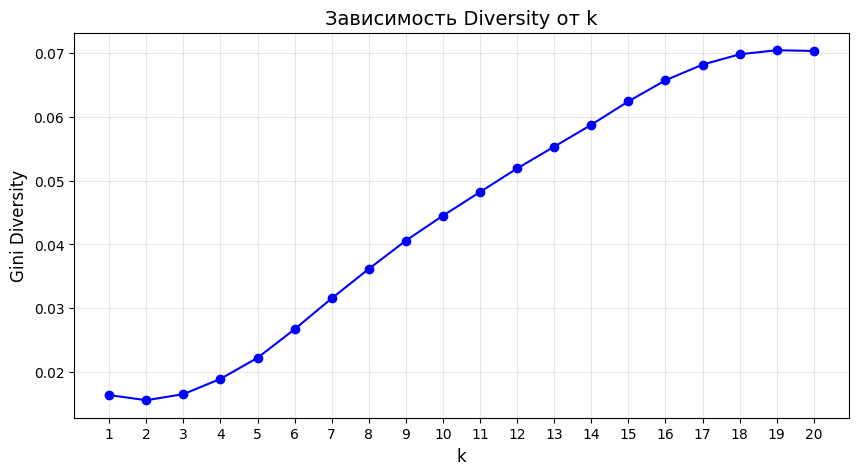

In [168]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(diversity_values.keys(), diversity_values.values(), marker='o', linestyle='-', color='b')
plt.xlabel('k', fontsize=12)
plt.ylabel('Gini Diversity', fontsize=12)
plt.title('Зависимость Diversity от k', fontsize=14)
plt.xticks(range(1, 21))
plt.grid(True, alpha=0.3)
plt.show()